In [1]:
# This program replicates figure 11 A and B in the appendix. To replicate #set Fig="A" to replicate figure 11 A and 
# set Fig="B" to replicate figure 11 B in the Appendix 

In [2]:
# Install necessary libraries (if not already installed): pandas for data manipulation, plotnine for ggplot2-like plots in Python
#!pip install pandas plotnine

# Import the pandas library for data manipulation and analysis
import pandas as pd

# Import the numpy library for numerical operations
import numpy as np

# Import matplotlib's pyplot for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# From pandas, import DataFrame for handling data in a table-like structure
from pandas import DataFrame

# From mpl_toolkits.mplot3d, import Axes3D for 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

# Import plotnine for creating complex plots using a grammar of graphics approach
import plotnine

# From plotnine, import all (*) to use its functions directly without prefixing them with plotnine.
from plotnine import *

# Import statsmodels' formula API for fitting statistical models using formulas
import statsmodels.formula.api as sm

# From numpy.random, import default_rng to create a new instance of the default random number generator
from numpy.random import default_rng

# Import Parallel and delayed functions from the joblib library. 
# Parallel is used for parallel computing, allowing for the execution of functions in parallel
# across multiple processors, delayed is a helper function that wraps the function to be executed in parallel, 
# making it easy to parallelize loops and function calls.
from joblib import Parallel, delayed

In [3]:
#set Fig="A" to replicate figure 11 A and set Fig="B" to replicate figure 11 B in the Appendix 
Fig="B"

In [4]:
# Update the path variable to the directory where the Figures will be stored.
#path = "C:\\Users\\Lena Sheveleva\\OneDrive - Cardiff University\\MPF_Facts_And_Fiction\\Replication Package\\Includes-python"
path =  r'..\Includes-python'

In [5]:
#Function prod_dest_distr is called by function correlate_ranks below 

# As inputs the function take the number of destinations that a firm serves (c), the number of products exported, and 
# whether fig A or be B is replicated Fig.

#output is a set of two np arrays for product and country ids imitating a typical record for a firm in  a customs dataset

def prod_dest_distr(c, scopeG, Fig):
    # Initialize empty lists for hsV and an empty numpy array for cV to store our results.
    hsV = []
    cV = np.array([], dtype=int)
    
    # Check if Fig is "A" to determine the processing logic.
    if Fig == "A":
        # Generate a list of product IDs from 1 to scopeG.
        hs = [x for x in range(1, scopeG + 1)]
        # Iterate over the range up to c to simulate different conditions or categories.
        for j in range(0, c):       
            if j == 0:
                # For the first iteration, simply assign hs to hsV and create an array of zeros for cV.
                hsV = hs
                cV = j * np.ones((len(hsV),), dtype=int)
            else:
                # For subsequent iterations, concatenate new values to cV and hsV to simulate the distribution.
                cV = np.concatenate((cV, j * np.ones((len(hs),), dtype=int)), axis=0)
                hsV = np.concatenate((hsV, hs), axis=0)
    elif Fig == "B":
        # This block is executed if Fig is "B", employing a simplified scenario where hs is fixed.
        hs = [1]
        for j in range(0, c):
            if j == 0:
                # Similar to Fig "A", but starts with a predefined list for hsV in the first iteration.
                hsV = [x for x in range(1, scopeG + 1)]
                cV = j * np.ones((len(hsV),), dtype=int)
            else:
                # For further iterations, the process is similar, simulating a different condition or category.
                cV = np.concatenate((cV, j * np.ones((len(hs),), dtype=int)), axis=0)
                hsV = np.concatenate((hsV, hs), axis=0)
    
    # Return the results as a list containing cV and hsV.
    return [cV, hsV]


In [6]:
def correlate_ranks(c, scopeG, f):
    
    # The function models the distribution of product exports to various destinations (countries) 
    # and evaluates the correlation between the ranking of product sales within each destination and 
    # across all destinations globally.
    
    # Parameters:
    # c: Number of countries (destinations).
    # scopeG: Total number of unique products exported across all destinations.
    # f: Number of firms exporting products.

    # Initialize distribution of products and destinations for a representative firm
    [cV, hsV] = prod_dest_distr(c, scopeG, Fig)
                
    Nf = len(cV)  # Total number of product-destination pairs.
    
    # Repeat cV and hsV f times to simulate multiple firms exporting the same set of products to the same set of destinations.
    c_v = np.tile(cV, f)  # Destination index for each firm.
    h_v = np.tile(hsV, f)  # Product index for each firm.
    f_v = np.repeat(np.arange(f), Nf)  # Firm index.

    Nd = len(f_v)  # Total number of observations (firm-product-destination triples).
    rng = default_rng(1)  # Initialize random number generator for reproducibility.
    values = pd.Series(np.exp(rng.standard_normal(Nd)))  # Simulate sales figures with log-normal distribution.

    # Create a dataframe to organize the simulated data.
    df = pd.DataFrame({'id': f_v, 'destination': c_v, 'product_code': h_v, 'sales': values})
    
    df["rank"] = np.nan  # Initialize rank column for later use.

    # Function to rank products by their sales within each firm-destination group.
    def func(group):
        group['rank'] = group['sales'].rank(ascending=False)
        return group

    # Apply the ranking function to each firm-destination group.
    df = df.groupby(['id', 'destination']).apply(func)

    # Aggregate sales data at the firm-product level and prepare for global ranking.
    df1 = df.groupby(['id', 'product_code']).sum().drop(columns=['destination'])
    df1["rank_gl"] = np.nan  # Initialize column for global rank within each firm.

    # Function to rank products by their aggregated sales within each firm.
    def func_global(group):
        group['rank_gl'] = group['sales'].rank(ascending=False)
        return group

    # Apply the global ranking function to each firm.
    df1 = df1.groupby('id').apply(func_global)
    df1 = df1.rename(columns={"sales": "sales_gl"}).drop(columns=['rank'])
    
    # Merge the global and local rank dataframes to analyze correlation.
    df2 = df1.merge(df, on=['id', 'product_code'])
    df2['rank'] = df2['rank'].astype(int)
    df2['rank_gl'] = df2['rank_gl'].astype(int)
    
    # Calculate and return the Pearson correlation coefficient between local and global product sales ranks.
    corr = df2['rank'].corr(df2['rank_gl'])

    return [corr]



In [7]:
    print(correlate_ranks(5,6,100))  

[0.8087694350521841]


In [8]:
# Number of countries and number of products exported 
Nc = 20
scopeG_max = 20

In [9]:
# Prepare a list of all possible (c, scopeG) pairs for given ranges.
# c_values and scopeG_values represent the ranges of possible values for c and scopeG, respectively.
# c ranges from 1 to Nc-1, and scopeG ranges from 2 to scopeG_max.
# This is useful for scenarios where you need to iterate over multiple configurations of c and scopeG,
# such as in simulations, data generation, or analysis tasks.

# Generate an array of c values, starting from 1 up to Nc-1.
c_values = np.arange(1, Nc)  

# Generate an array of scopeG values, starting from 2 up to scopeG_max. (export at least 2 products)
scopeG_values = np.arange(2, scopeG_max + 1)  

# Use np.meshgrid to create two 2D arrays: C and ScopeG.
# C contains repeated rows of c_values, and ScopeG contains repeated columns of scopeG_values.
# This creates a grid of all possible (c, scopeG) combinations.
C, ScopeG = np.meshgrid(c_values, scopeG_values)

# Flatten the 2D arrays C and ScopeG to create a list of pairs.
# Each pair (c, scopeG) represents a unique combination of c and scopeG values.
pairs = list(zip(C.flatten(), ScopeG.flatten()))


In [10]:
# This function wraps the original call to correlate_ranks
# and prepares the data structure you want to end up with.
def process_pair(c_scopeG):
    f=10000
    c, scopeG = c_scopeG
    corr = correlate_ranks(c, scopeG, f)  # Assuming this function returns [corr]
    # Prepend c and scopeG to the result
    return [c, scopeG] + corr

In [11]:
# Execute the process_pair function in parallel across multiple processor cores.
# The process_pair function is applied to each element in the 'pairs' list.
# 'Parallel' creates a pool of workers (processes), with the number of workers specified by n_jobs.
# Here, n_jobs=60 indicates that up to 60 tasks can be run in parallel, depending on the availability of resources.
# 'delayed' wraps the process_pair function, ensuring it's called with each element from 'pairs' as its argument.
# This parallel execution is especially beneficial for computationally intensive tasks or processing large datasets,
# as it can significantly reduce the overall execution time by making use of multiple cores.

results = Parallel(n_jobs=60)(delayed(process_pair)(i) for i in pairs)


In [12]:
# Convert results to a DataFrame
df3 = pd.DataFrame(results, columns=["country", "scope", "corr"])

# Display the first few rows of the DataFrame
df3


,country,scope,corr
0,1,2,1.000000
1,2,2,0.466477
2,3,2,0.390208
3,4,2,0.367078
4,5,2,0.399610
...,...,...,...
356,15,20,0.952706
357,16,20,0.953073
358,17,20,0.955351
359,18,20,0.956200


In [13]:
# Convert the 'country' and 'scope' columns from strings or floats to integers.
# This conversion is necessary for correct plotting and grouping in the ggplot,
# as these fields are expected to be numeric (especially 'country' if it's being used in a logarithmic scale).
df3['country'] = df3['country'].apply(int)
df3['scope'] = df3['scope'].apply(int)


C:\ProgramData\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\ProgramData\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Includes-python/Fig11B.pdf


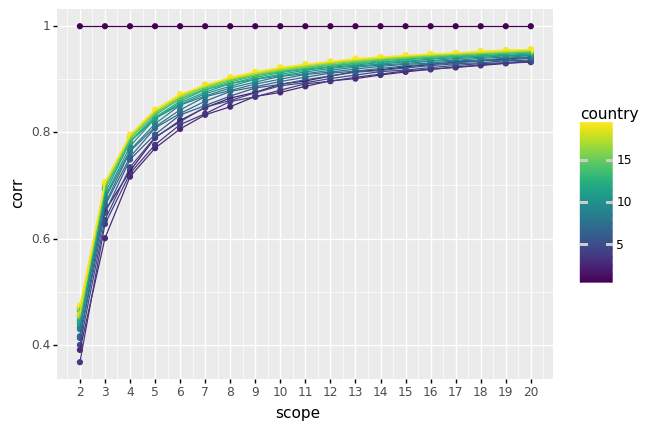

<ggplot: (161298946684)>

In [14]:
# Create a ggplot object named p2. The plot visualizes the relationship between 'country' and 'corr',
# with different 'scope' values represented as both colors and groups.

# 'aes' defines the aesthetics of the plot, mapping 'country' to the x-axis, 'corr' to the y-axis,
#  and 'scope' to both the color and the grouping of points and lines.

# 'geom_point' adds points to the plot, one for each row in df3, allowing us to see the distribution of 'corr' values across countries.

# 'geom_line' connects these points with lines, grouped by 'scope', to illustrate how 'corr' changes across countries within each scope.

# 'scale_x_continuous' is used to set the x-axis to a logarithmic scale, improving readability when 'country' values span several orders of magnitude.
# The 'breaks' parameter explicitly sets the tick marks on the x-axis to specific values, enhancing the plot's interpretability.

p=ggplot(df3, aes(x='scope', y='corr', group = 'country',color = 'country'))+ \
    geom_point()+ \
    geom_line()+\
    scale_x_continuous(breaks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

full_path = f"{path}/Fig11{Fig}.pdf"
ggsave(plot = p, filename = full_path)

p